Import

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

Ekstrak fitur

In [2]:
def extract_features(image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (128, 128))

    # Convert to grayscale
    gray_image = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

    # Texture Features: GLCM (Gray Level Co-occurrence Matrix)
    glcm = graycomatrix(gray_image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))

    # Color Features: Grayscale Histogram
    gray_hist = cv2.calcHist([gray_image], [0], None, [32], [0, 256])  # 32 bins for grayscale histogram
    gray_hist = cv2.normalize(gray_hist, gray_hist).flatten()

    # Shape Features: Edge and Contour Analysis
    edges = cv2.Canny(gray_image, 50, 150)
    edge_density = np.sum(edges) / (512 * 512)

    # Combine all features
    features = np.hstack([gray_hist, [contrast, correlation, energy, homogeneity, edge_density]])
    return features

set data set

In [7]:
# Load dataset
dataset_path = "data"  # Update with the correct path
classes = os.listdir(dataset_path)

X=[]
y=[]

for class_label, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)  # Training dataset path
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        try:
            features = extract_features(image_path)
            X.append(features)
            y.append(class_label)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

X=np.array(X)
y=np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

print(f"Feature Vector Shape: {X_train.shape}")
print(f"Labels Shape: {y_train.shape}")

Feature Vector Shape: (2704, 37)
Labels Shape: (2704,)


train

In [8]:
# Scale the training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='minkowski', p=2)
knn.fit(X_train, y_train)

print("Model trained!")

Model trained!


summary

In [9]:
# Scale the test data using the training scaler
X_test = scaler.transform(X_test)

# Predict the test labels
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on new test data: {accuracy}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

Accuracy on new test data: 0.9659763313609467
Classification Report:
              precision    recall  f1-score   support

       Hujan       0.99      0.94      0.97       338
  Ndak Hujan       0.94      0.99      0.97       338

    accuracy                           0.97       676
   macro avg       0.97      0.97      0.97       676
weighted avg       0.97      0.97      0.97       676



Metrics Summary:
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 Score: 0.97


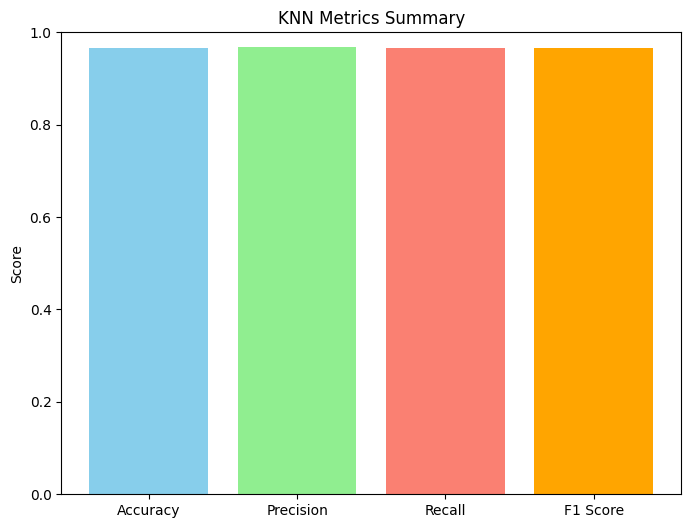

In [10]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# Metrics summary
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
}

# Print metrics
print("Metrics Summary:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Plotting the metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.title("KNN Metrics Summary")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

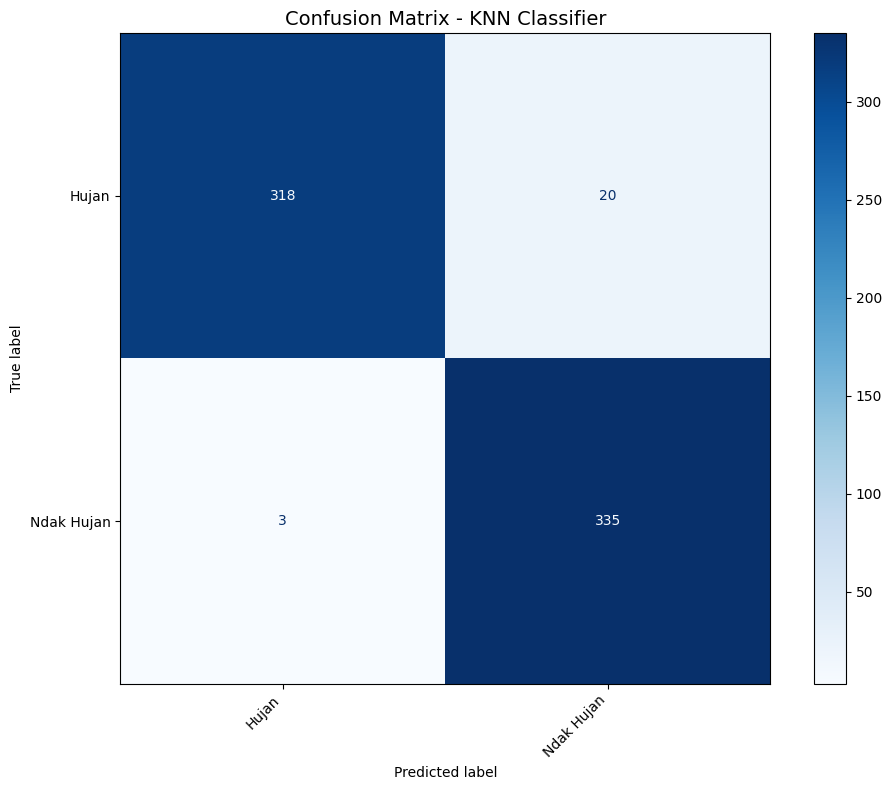

In [11]:
# Create Confusion Matrix Display
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size to avoid overlap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix with adjustments
disp.plot(cmap="Blues", ax=ax, colorbar=True)
ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
ax.set_yticklabels(classes, fontsize=10)  # Adjust y-axis labels font size
plt.title("Confusion Matrix - KNN Classifier", fontsize=14)
plt.tight_layout()  # Ensure everything fits without overlap
plt.show()

Predict

Predicted Cloud Class: Hujan


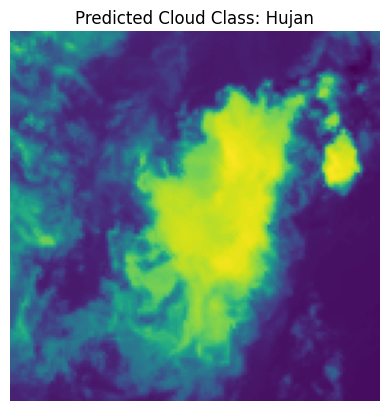

In [12]:
def predict_image(image_path):
    features = extract_features(image_path)
    features = scaler.transform([features])  # Standardize features
    prediction = knn.predict(features)[0]
    return classes[prediction]

# Provide a test image path
new_image_path = "data/Hujan/2022-11-10 06_30.png"  # Replace with your test image
predicted_class = predict_image(new_image_path)
print(f"Predicted Cloud Class: {predicted_class}")

predicted_class = predict_image(new_image_path)
image = Image.open(new_image_path)
plt.imshow(image)
plt.title(f"Predicted Cloud Class: {predicted_class}")
plt.axis("off")
plt.show()